#  Decision Trees


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error

# Data Sample Load

Load [titanic](https://gist.github.com/michhar/2dfd2de0d4f8727f873422c5d959fff5) dataset.

    VARIABLE DESCRIPTIONS:
    survival        Survival
                (0 = No; 1 = Yes)
    pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
    name            Name
    sex             Sex
    age             Age
    sibsp           Number of Siblings/Spouses Aboard
    parch           Number of Parents/Children Aboard
    ticket          Ticket Number
    fare            Passenger Fare
    cabin           Cabin
    embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

    SPECIAL NOTES:
    Pclass is a proxy for socio-economic status (SES)
     1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

    Age is in Years; Fractional if Age less than One (1)
     If the Age is Estimated, it is in the form xx.5

In [2]:
#data = pd.read_csv('titanic.csv')
data = pd.read_csv('https://grantmlong.com/data/titanic.csv')

In [3]:
def data_preprocessing(data_input):

    # Select bad columns and remove them
    cols_2_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
    data_input = data_input.drop(cols_2_drop, axis=1)

    # Replace missing values (NaN) with -999 for 'Age' feature
    data_input.loc[:, 'Age'] = data_input.Age.fillna(-999)

    # Encode 'Sex' values
    data_input.loc[:, 'Sex'] = data_input.Sex.replace({'male': 0, 'female': 1})

    # Remove all object with missing values
    data_input = data_input.dropna()

    # Encode categorical features using OneHotEncoding
    data_input = pd.get_dummies(data_input, columns=['Embarked'], prefix_sep='=')

    return data_input

In [4]:
data_preproc = data_preprocessing(data)

/var/folders/h0/z7lpdx1d2l5gfkb9nt4d_rjc0000gn/T/ipykernel_5289/1192166764.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_input.loc[:, 'Sex'] = data_input.Sex.replace({'male': 0, 'female': 1})


In [5]:
data_preproc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked=C,Embarked=Q,Embarked=S
0,0,3,0,22.0,1,0,7.2500,False,False,True
1,1,1,1,38.0,1,0,71.2833,True,False,False
2,1,3,1,26.0,0,0,7.9250,False,False,True
3,1,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,0,35.0,0,0,8.0500,False,False,True


# EDA


In [6]:
# Set up label column
y_column = "Survived"

# Select X columns
X_columns = data_preproc.columns[data_preproc.columns != y_column]

X_columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked=C',
       'Embarked=Q', 'Embarked=S'],
      dtype='object')

/Users/andrey/projects/otus/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6862: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


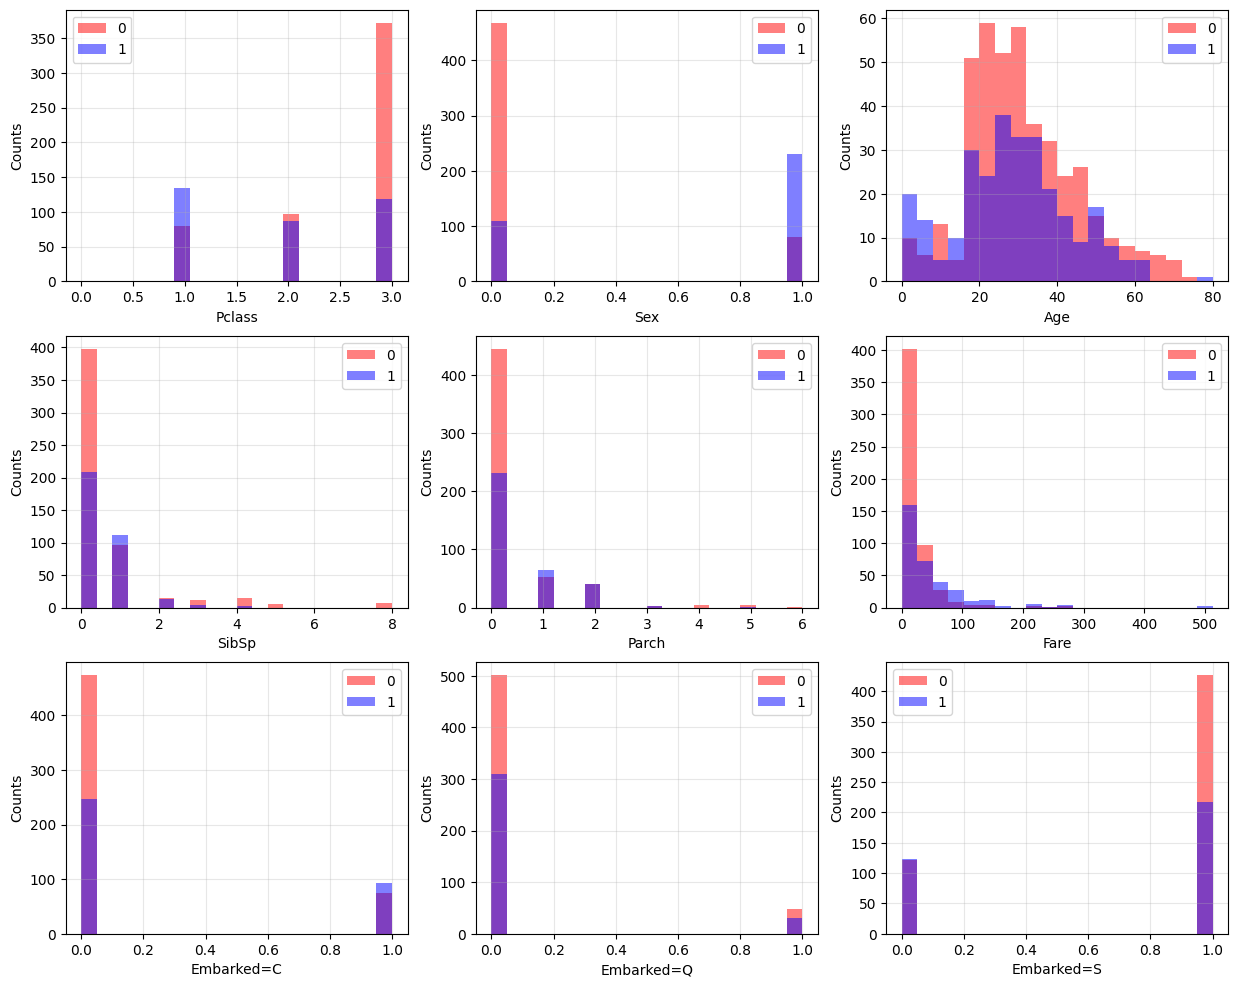

In [7]:
# Define size of the figure
plt.figure(figsize=(15, 12))

# For each column ...
for i_col in range(len(X_columns)):

    # Create subplot for each column
    plt.subplot(3, 3, i_col+1)

    # Get column and label values
    x_col = data_preproc[X_columns[i_col]].values
    y_col = data_preproc[y_column].values

    # Plot histograms
    bins = np.linspace(0, x_col.max(), 21)
    plt.grid(alpha = 0.3)
    plt.hist(x_col[y_col == 0], bins=bins, color='r', alpha=0.5, label='0')
    plt.hist(x_col[y_col == 1], bins=bins, color='b', alpha=0.5, label='1')

    # Labels and legend
    plt.xlabel(X_columns[i_col])
    plt.ylabel('Counts')
    plt.legend(loc='best')

plt.show()

## Data Split


In [8]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split
X = data_preproc[X_columns].values
y = data_preproc[y_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,    # 20% for test, 80% for train
                                                    random_state=123) # shuffle objects before split

# Decision Tree

**Decision Tree** is a non-parametric supervised ML algorithm used for classification and regression.



**Idea** break down a dataset into smaller and smaller subsets while at the same time an assosiated decision tree is incrementally developed.

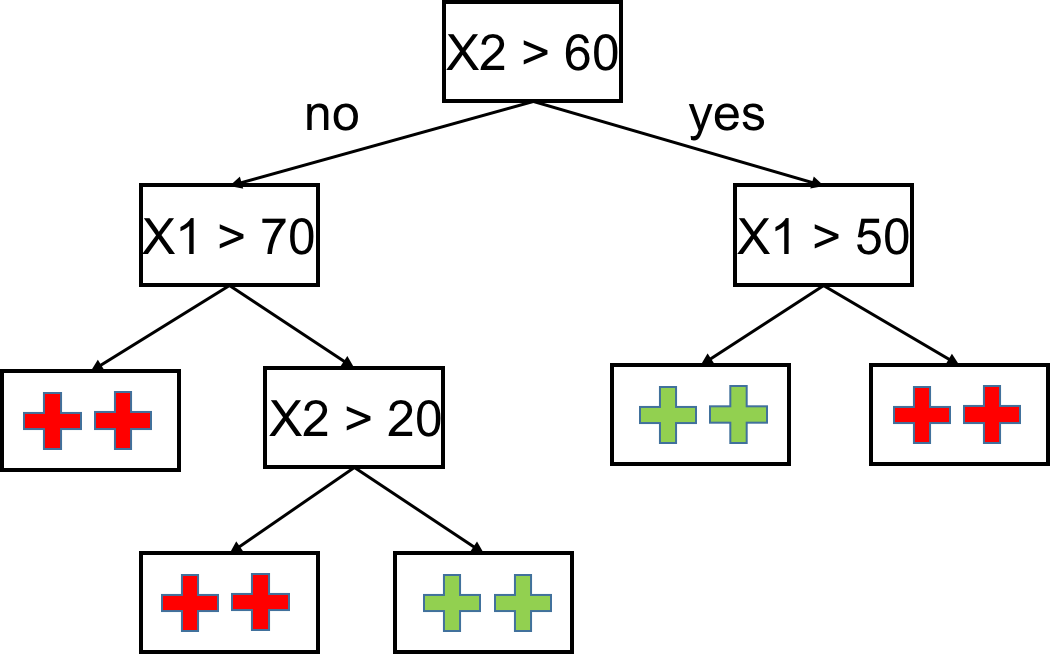

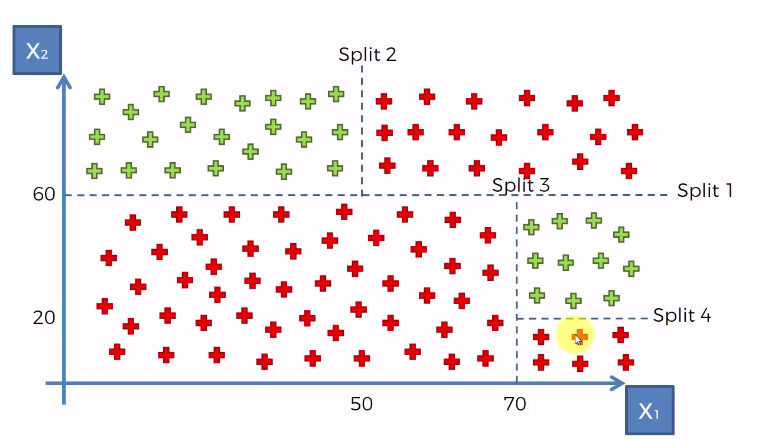

# Decision tree classifier

Decision tree building is started from the root node. The selection rule is estimated to maximize **information gain** for the node plit:

$$
\Delta I_{node} = I_{node} - (I_{left} \frac{N_{left}}{N_{node}} + I_{right} \frac{N_{right}}{N_{node}})
$$

where $I_{node}$ is impurity of a node.

## Popular impurity functions

**Gini**

Gini index or Gini impurity measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen. But what is actually meant by ‘impurity’? If all the elements belong to a single class, then it can be called pure. The degree of Gini index varies between 0 and 1, where 0 denotes that all elements belong to a certain class or if there exists only one class, and 1 denotes that the elements are randomly distributed across various classes. A Gini Index of 0.5 denotes equally distributed elements into some classes.

$$
I_{node} = G(node) = \sum_{i}^{C}p_{i}(1 - p_{i}) = 1 - \sum_{i}^{C}p_{i}^2
$$

**Entropy**

Entropy is the degree of uncertainty, impurity or disorder. In this case we aim to reduce the level of entropy and, thus, to reduce the chaos and "gain information".

$$
I_{node} = E(node) = -\sum_{i}^{C}p_{i}log(p_{i})
$$

**Classification error**

$$
I_{node} = 1 - \max_{i}p_{i}
$$

where $p_{i}$ is fraction of objects of class $i$ in the node:

$$
p_{i} = \frac{N_{i}}{\sum_{i}^{C}N_{i}}
$$

Let's look at the example:




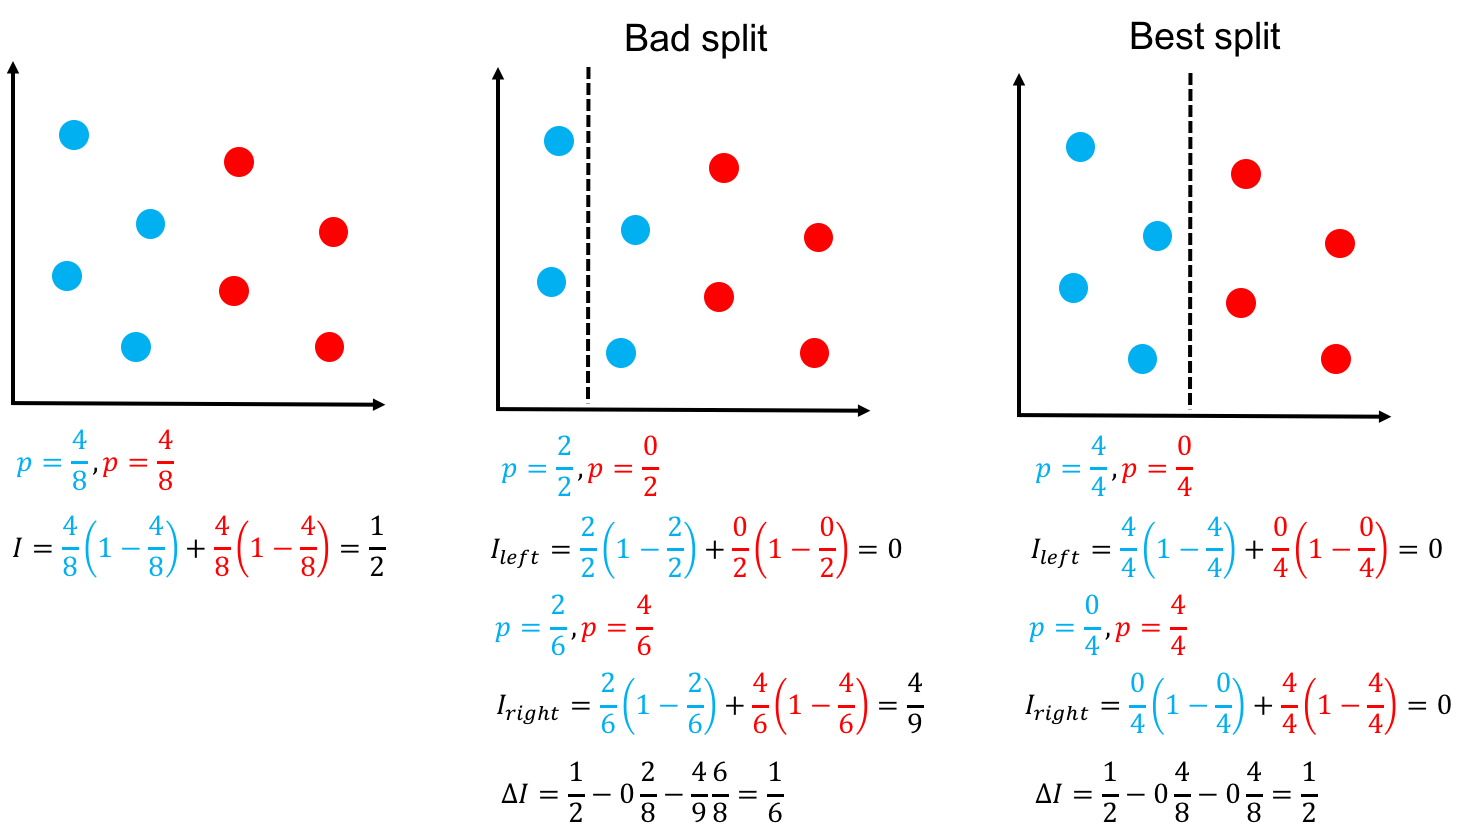

[Good explanation](https://blog.quantinsti.com/gini-index/#Information-Gain) of impurity criteria.

**Prediction stage**

At the prediction stage the class of the example is predicted as the most popular class in the `Leaf` where it falls.

## Decision Tree Classifier from scratch

Let's implement Decision Tree classifier.

Do not be scared, it is not that difficult!

In [9]:
class Node(object):

    def __init__(self):
        """
        Class for a decision tree node.
        """

        self.right = None
        self.left = None

        self.threshold = None
        self.column = None

        self.depth = None
        self.probas = None

        self.is_terminal = False

In [10]:
class DecisionTreeClassifier_from_scratch(object):

    def __init__(self, max_depth=3, min_samples_leaf=1, min_samples_split=2, impurity='gini'):
        """
        Class for a Decision Tree Classifier.

        Parameters
        ----------
        max_depth : int
            Max depth of a decision tree.
        min_samples_leaf : int
            Minimal number of samples (objects) in a leaf (terminal node).
        min_samples_split : int
            Minimal number of samples (objects) in a node to make a split.
        impurity : str
            Impurity function used for the decision tree building.
        """

        # Make hyperparameters visible inside the class
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.impurity = impurity

        # Object for the decision tree
        self.Tree = None

        # Helping objects
        self.classes = []

    def get_params(self, deep=True):
        """
        Returns class parameters.

        Parameters
        ----------
        deep : boolean
            If True, will return the parameters for this estimator and contained subobjects that are estimators.

        Returns
        -------
        params : dict
            Parameters of the class.
        """

        params = {'max_depth': self.max_depth,
                  'min_samples_leaf': self.min_samples_leaf,
                  'min_samples_split': self.min_samples_split,
                  'impurity': self.impurity}

        return params


    def set_params(self, **params):
        """
        Set class parameters.

        Parameters
        ----------
        params : dict
            Dictionary of the class parameters.
        """

        for key, value in params.items():
            setattr(self, key, value)

        return self



    def node_probabilities(self, y):
        """
        Estimate probabilities of classes in data.

        Parameters
        ----------
        y : numpy.array, shape = (n_objects)
            1D array with the object labels.
            For the classification labels are integers in {0, 1, 2, ...}.

        Returns
        -------
        probas : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class.
            Example:
                y_predicted_proba = [[0.1, 0.9],
                                     [0.8, 0.2],
                                     [0.0, 1.0],
                                     ...]
        """

        # To store probas
        probas = []

        # For each class in data ...
        for one_class in self.classes:

            # Estimate probability of the class
            class_proba = 1. * (y == one_class).sum() / len(y)
            # class_proba = 0.8 (example)

            # Store the probability
            probas.append(class_proba)

        return probas


    def gini_calculation(self, probas):
        """
        Calculate gini value.

        Parameters
        ----------
        probas : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class.
            Example:
                probas = [0.1, 0.9]

        Returns
        -------
        gini : float
            Gini value.
        """

        gini = 1
        for p in probas:
            gini -= p**2

        return gini


    def impurity_calculation(self, y):
        """
        Calculate data impurity.

        Parameters
        ----------
        y : numpy.array, shape = (n_objects)
            1D array with the object labels.
            For the classification labels are integers in {0, 1, 2, ...}.

        Returns
        -------
        impurity : float
            Impuroty of the data.
        """

        # Estimate probabilities for each class
        probas = self.node_probabilities(y)
        # probas = [0.90, 0.10] (example)

        # Calculate impurity of the data
        if self.impurity == 'gini':
            impurity = self.gini_calculation(probas)
            # impurity = 0.6 (example)

        return impurity


    def best_split(self, X, y):
        """
        Make the best split of data in a decision tree node.

        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels.
            For the classification labels are integers in {0, 1, 2, ...}.

        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : numpy.array, shape = (n_objects, n_features)
            Matrix of objects in the left child that are described by their input features.
        y_left : numpy.array, shape = (n_objects)
            1D array with the object labels in the left child.
            For the classification labels are integers in {0, 1, 2, ...}.
        X_right : numpy.array, shape = (n_objects, n_features)
            Matrix of objects in the right child that are described by their input features.
        y_right : numpy.array, shape = (n_objects)
            1D array with labels of the objects in the right child.
            For the classification labels are integers in {0, 1, 2, ...}.
        """

        # To store best split parameters
        best_split_column = None
        best_threshold = None
        best_information_gain = -999

        # Data impurity before the split
        impurity = self.impurity_calculation(y)
        # impurity = 0.8 (example)

        # For each column in X ...
        for split_column in range(X.shape[1]):

            # Select values of the column
            x_col = X[:, split_column]
            # x_col = [2.6, 1.3, 0.5, ...] (example)

            # For each value in the column ...
            for i_x in range(0, len(x_col)):

                # Take the value as a threshold for a split
                threshold = x_col[i_x]
                # threshold = 1.3 (example)

                # Make the split into right and left childs
                y_right = y[x_col > threshold]
                y_left = y[x_col <= threshold]
                # y_left = [0, 1, 1, 0, 1] (example)

                if len(y_right) == 0 or len(y_left) == 0:
                    continue

                # Calculate impurity for each child
                impurity_left = self.impurity_calculation(y_left)
                impurity_right = self.impurity_calculation(y_right)
                # impurity_right = 0.6 (example)

                # Calculate information gain of the split
                information_gain = impurity
                information_gain -= impurity_left * len(y_left) / len(y)
                information_gain -= impurity_right * len(y_right) / len(y)
                # information_gain = 0.2 (example)

                # Is this information_gain the best?
                if information_gain > best_information_gain:
                    best_split_column = split_column
                    best_threshold = threshold
                    best_information_gain = information_gain

        # If no split available
        if best_information_gain == -999:
            return None, None, None, None, None, None

        # Take the best split parameters and make this split
        x_col = X[:, best_split_column]
        X_left = X[x_col <= best_threshold, :]
        y_left = y[x_col <= best_threshold]
        X_right = X[x_col > best_threshold, :]
        y_right = y[x_col > best_threshold]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right



    def decision_tree(self, node, X, y):
        """
        Functions builds a decision tree.

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels.
            For the classification labels are integers in {0, 1, 2, ...}.
        """

        # Check termination conditions
        if node.depth >= self.max_depth:      # max_depth check
            node.is_terminal = True
            return
        if len(X) < self.min_samples_split:   # min_samples_split check
            node.is_terminal = True
            return
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return

        # Make best split
        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y) # Make a split
        # split_column = 2 (exmaple) column index of the split
        # threshold = 2.74 (example) split_column > threshold

        # Check additional termination conditions
        if split_column is None:
            node.is_terminal = True
            return
        if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:  # min_samples_leaf check
            node.is_terminal = True
            return


        # Add split parameters into the current node
        node.column = split_column
        node.threshold = threshold

        # Create a left child of the current node
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.probas = self.node_probabilities(y_left)

        # Create a right child of the current node
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.probas = self.node_probabilities(y_right)

        # Make splits for the left and right nodes
        self.decision_tree(node.right, X_right, y_right)
        self.decision_tree(node.left, X_left, y_left)


    def fit(self, X, y):
        """
        Fit the Decision Tree Classifier.

        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels.
            For the classification labels are integers in {0, 1, 2, ...}.
        """

        # Get unique class labels
        self.classes = np.unique(y)
        # self.classes = [0, 1] (example)

        # Create a root node of a decision tree
        self.Tree = Node()                             # Create an empty node
        self.Tree.depth = 1                            # the node depth
        self.Tree.probas = self.node_probabilities(y)  # init class probabilities

        # Build the decision tree
        self.decision_tree(self.Tree, X, y)


    def one_prediction(self, node, x):
        """
        Functions builds a decision tree.

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : numpy.array, shape = (n_features,)
            Array of feature values of one object.
        """

        # Termination condition
        if node.is_terminal == True:     # If it is a leaf (terminal node, no childs)
            return node.probas                           # Return probas of the terminal node
            # node.probas = [0.9, 0.1] (example)

        # Run to the current node's childs
        # Check split condition. If yes, go to the right child
        if x[node.column] > node.threshold:
            # Right child
            probas = self.one_prediction(node.right, x)
            # probas = [0.9, 0.1] (example)
        else:
            # Left child
            probas = self.one_prediction(node.left, x)
            # probas = [0.9, 0.1] (example)

        return probas


    def predict_proba(self, X):
        """
        Predict class probabilities for unknown objects.

        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.

        Returns
        -------
        y_predicted_proba : numpy.array, shape = (n_objects, n_classes)
            2D array with predicted probabilities of each class.
            Example:
                y_predicted_proba = [[0.1, 0.9],
                                     [0.8, 0.2],
                                     [0.0, 1.0],
                                     ...]
        """

        # Create an empty list for predicted probabilities
        y_predicted_proba = []

        # For each object in X make a prediction
        for one_x in X:

            # Make the prediction for one object
            one_proba = self.one_prediction(self.Tree, one_x)
            # one_proba = [0.9, 0.1] (example)

            # Store the predictions
            y_predicted_proba.append(one_proba)

        return np.array(y_predicted_proba)


    def predict(self, X):
        """
        This methods performs labels prediction for new objects.

        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.

        Returns
        -------
        y_predicted : numpy.array, shape = (n_objects)
            1D array with predicted labels.
            For the classification labels are integers in {0, 1, 2, ...}.
        """

        # Predict probabilities
        y_predicted_proba = self.predict_proba(X)
        # y_predicted_proba = [[0.90, 0.10],
        #                      [0.23, 0.77],
        #                       ...]  (example)

        # Find class labels with the highest probability
        y_predicted = y_predicted_proba.argmax(axis=1)
        # y_predicted = [0, 1] (example)

        return y_predicted

In [11]:
%time
clf = DecisionTreeClassifier_from_scratch(max_depth=10, min_samples_leaf=1, min_samples_split=2, impurity='gini')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


In [12]:
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [13]:
y_test[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [14]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       161
           1       0.81      0.62      0.71       106

    accuracy                           0.79       267
   macro avg       0.80      0.76      0.77       267
weighted avg       0.80      0.79      0.79       267



**Task:** Modify Decision Tree Classifier, implement Entropy criterion.

In [15]:
## YOUR CODE HERE

## Sklearn implementation

Let us also look at sklearn implementatiom.

    class sklearn.tree.DecisionTreeClassifier(*, criterion='gini',
    splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1,
    min_weight_fraction_leaf=0.0, max_features=None, random_state=None,
    max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
    class_weight=None, ccp_alpha=0.0)

In [16]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, criterion='gini')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       161
           1       0.86      0.65      0.74       106

    accuracy                           0.82       267
   macro avg       0.83      0.79      0.80       267
weighted avg       0.83      0.82      0.81       267



Not surprisingly results are the same as long as we implemented a simplified version of sklearn Decision Tree.

## Decision tree visualization





In [17]:
from sklearn.tree import export_graphviz
import os, graphviz,pydotplus
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
def plot_tree(model, cols, fname='temp_tree.png'):
    dot_data = export_graphviz(model, filled=True, rounded=True, feature_names=cols, out_file=None)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

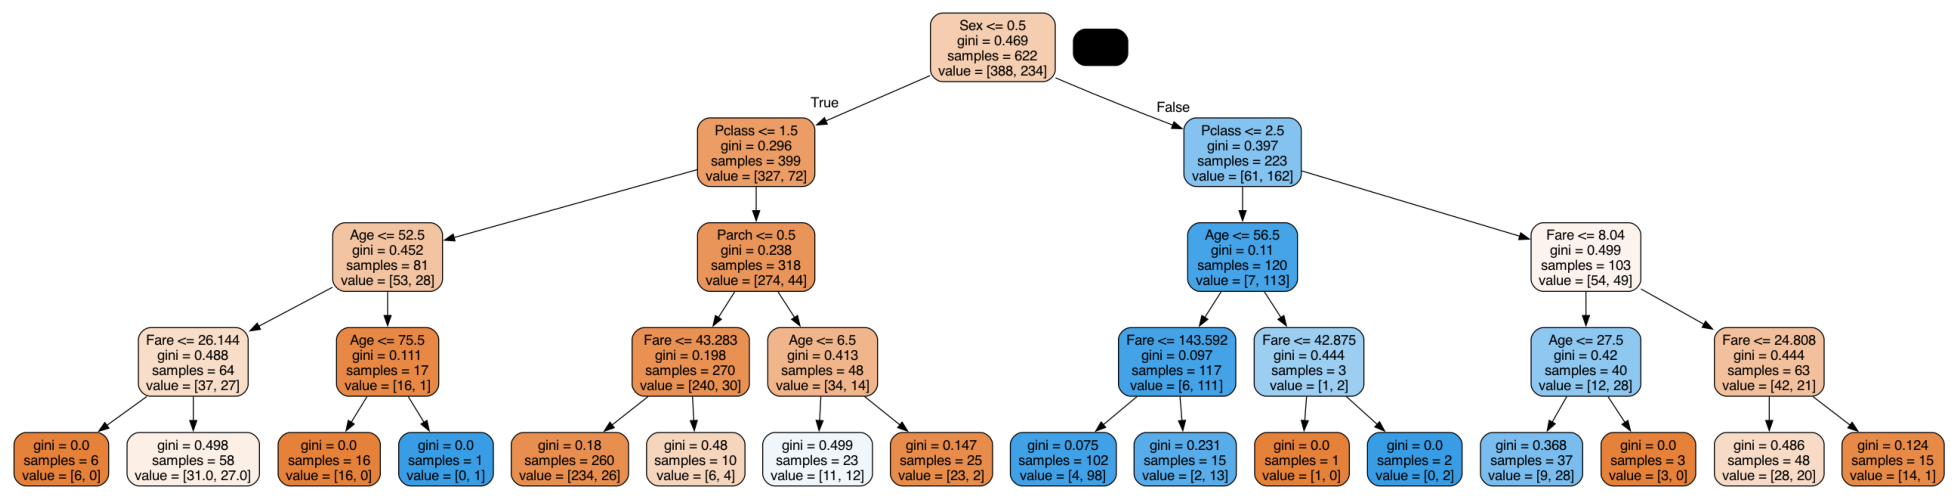

In [18]:
clf = DecisionTreeClassifier(max_depth=4, criterion='gini')
clf.fit(X_train, y_train)
plt.figure(figsize=(25, 25))
plt.axis('off')
plot_tree(clf, X_columns)

## What's wrong with Decision trees?

It's said that Decision trees have **high variance**. Small changes in data can lead to radically different trees.

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       166
           1       0.77      0.66      0.71       101

    accuracy                           0.80       267
   macro avg       0.79      0.77      0.78       267
weighted avg       0.80      0.80      0.79       267



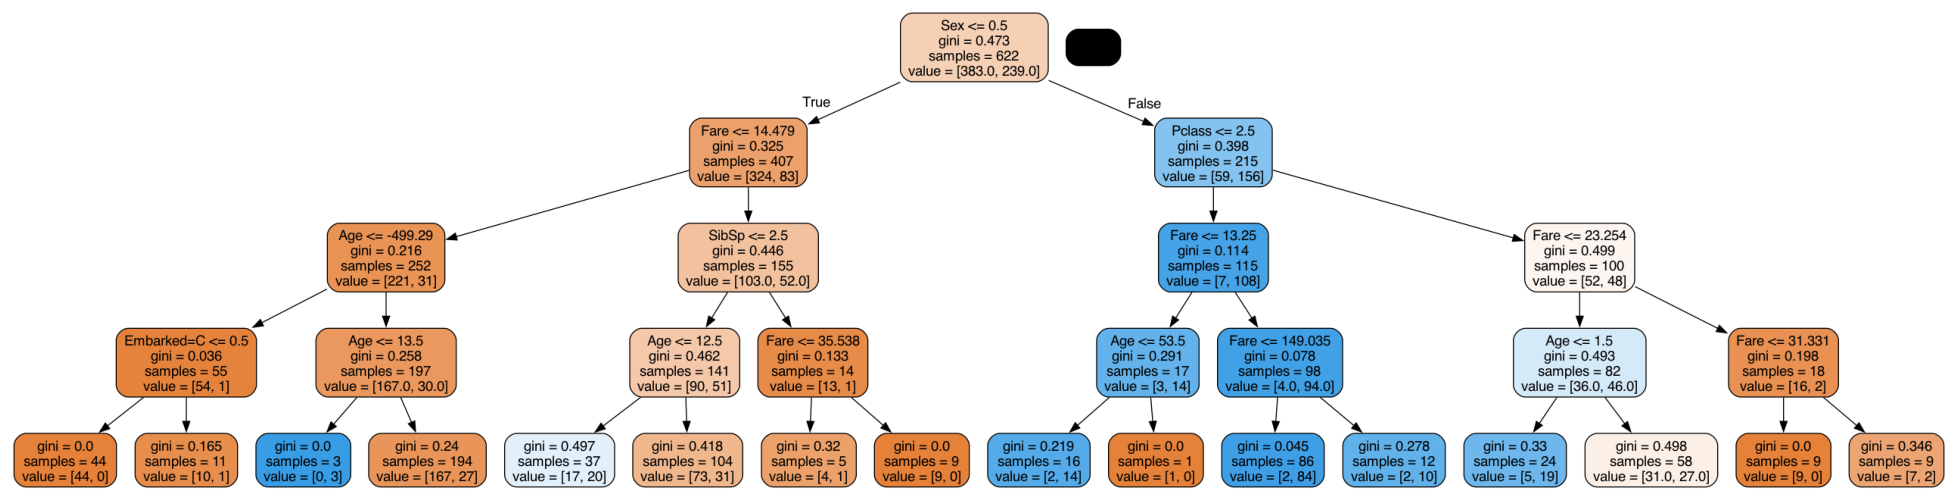

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,    # 20% for test, 80% for train
                                                    random_state=1) # shuffle objects before split
clf1 = DecisionTreeClassifier(max_depth=4, criterion='gini')
clf1.fit(X_train, y_train)
plt.figure(figsize=(25, 25))
plt.axis('off')
plot_tree(clf1, X_columns)
pred = clf1.predict(X_test)
print(classification_report(y_test, pred))

Just changing the random seed for the `train_test_split` has led to significant changes in the resulted tree and the accuracy has slightly changed as well.


# Hyperparameters optimization

Let's find optimal hyperparameters of the Decision Tree Classifier.

In [20]:
# Import GridSearchCV class
from sklearn.model_selection import GridSearchCV

# Define Decision Tree classifier with default parameters
clf = DecisionTreeClassifier()

# Estimate grid of the classifier hyperparameters
parameters = {'max_depth':[1, 3, 5, 7, 10],
              'min_samples_split' : [2,5,10,20],
              'min_samples_leaf':[1, 5, 10,50]}

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='accuracy',  # Claasification quality metric to optimize
                  cv=3)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [21]:
pred = gs.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       166
           1       0.84      0.73      0.78       101

    accuracy                           0.85       267
   macro avg       0.85      0.82      0.83       267
weighted avg       0.85      0.85      0.84       267



Congratulation! The score has improved!

## Parameter influence

**But what does these parameters actually mean and how do they influence the final tree?**

To understand this, let's consider a toy example of binary classification problem with two plain circles.

To make it more challeging we add noise randomly changing some labels.

In [22]:
from sklearn.datasets import make_moons, make_circles # import function from the library
import random
random.seed(1)

N = 1000

X, y = make_circles(n_samples=N, noise=0.1, factor=0.6, random_state=1)

#adding noise
for i, yy in enumerate(y):
    if random.randint(0,30)% 30 == 0:
        y[i] = (y[i]+1)%2

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,    # 20% for test, 80% for train
                                                    random_state=123) # shuffle objects before split

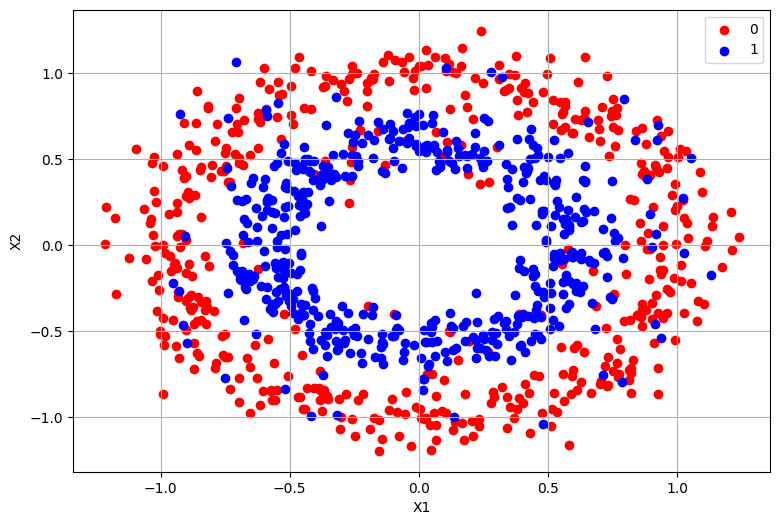

In [23]:
# Create an figure with a custom size
plt.figure(figsize=(9, 6))

# Plot all objects with y == 0 (class 0)
plt.scatter(X[y == 0, 0],     # selects all objects with y == 0 and the 1st column of X
            X[y == 0, 1],     # selects all objects with y == 0 and the 2nd column of X
            color='r',        # points color
            label='0')        # label for the plot legend


# Plot all objects with y == 1 (class 1)
plt.scatter(X[y == 1, 0],     # selects all objects with y == 1 and the 1st column of X
            X[y == 1, 1],     # selects all objects with y == 1 and the 2nd column of X
            color='b',        # points color
            label='1')        # label for the plot legend

plt.xlabel('X1') # set up X-axis label
plt.ylabel('X2') # set up Y-axis label

plt.legend(loc='best') # create the plot legend and set up it position
plt.grid() # create grid on the plot

plt.show() # display the plot

Our data represents two circles one inside the other with some noise.

**Baseline**
First, let's build a decision tree from the box.

In [24]:
%time
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       251
           1       0.80      0.78      0.79       249

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



In [25]:
def plot_desicion_boundaries():
    # Create an figure with a custom size
    plt.figure(figsize=(9, 6))

    # Plot all objects with y == 0 (class 0)
    plt.scatter(X_test[y_test == 0, 0],     # selects all objects with y == 0 and the 1st column of X
                X_test[y_test == 0, 1],     # selects all objects with y == 0 and the 2nd column of X
                color='r',                  # points color
                label='0')                  # label for the plot legend


    # Plot all objects with y == 1 (class 1)
    plt.scatter(X_test[y_test == 1, 0],     # selects all objects with y == 1 and the 1st column of X
                X_test[y_test == 1, 1],     # selects all objects with y == 1 and the 2nd column of X
                color='b',                  # points color
                label='1')                  # label for the plot legend


    ### THIS IS JUST MAGIC :)

    # plot decision boundary
    h=0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # Probas

    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.5, levels=1)

    ### THE END OF THE MAGIC


    plt.xlabel('X1') # set up X-axis label
    plt.ylabel('X2') # set up Y-axis label

    plt.legend(loc='best') # create the plot legend and set up it position
    plt.grid() # create grid on the plot
    plt.colorbar()

    plt.show() # display the plot

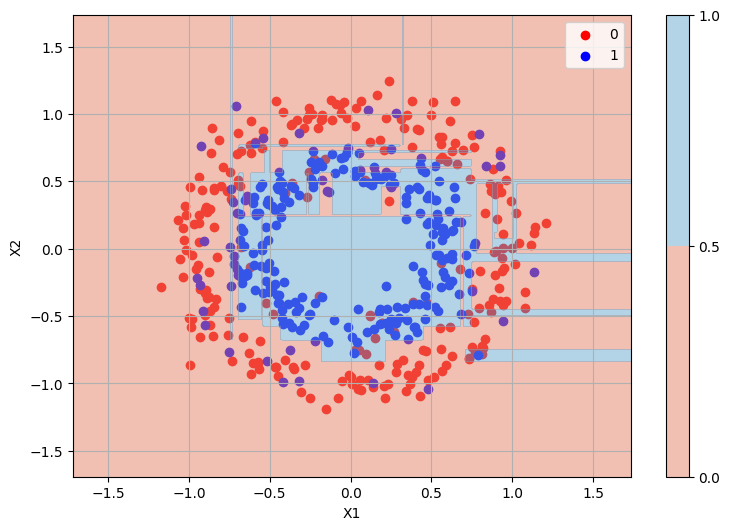

In [26]:
plot_desicion_boundaries()

Not bad, but it seems that the tree has overfitted due to noise.

**Max depth**

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs
Max_depth:  1
              precision    recall  f1-score   support

           0       0.84      0.24      0.38       251
           1       0.56      0.95      0.70       249

    accuracy                           0.60       500
   macro avg       0.70      0.60      0.54       500
weighted avg       0.70      0.60      0.54       500



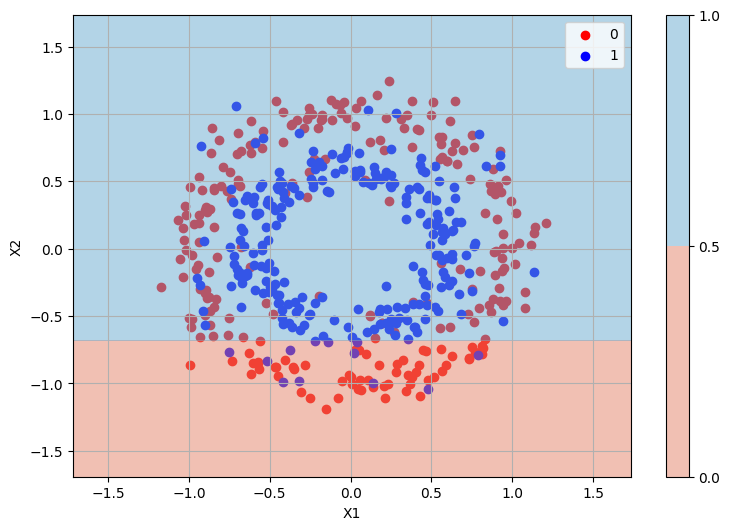

Max_depth:  2
              precision    recall  f1-score   support

           0       0.81      0.47      0.60       251
           1       0.63      0.89      0.74       249

    accuracy                           0.68       500
   macro avg       0.72      0.68      0.67       500
weighted avg       0.72      0.68      0.67       500



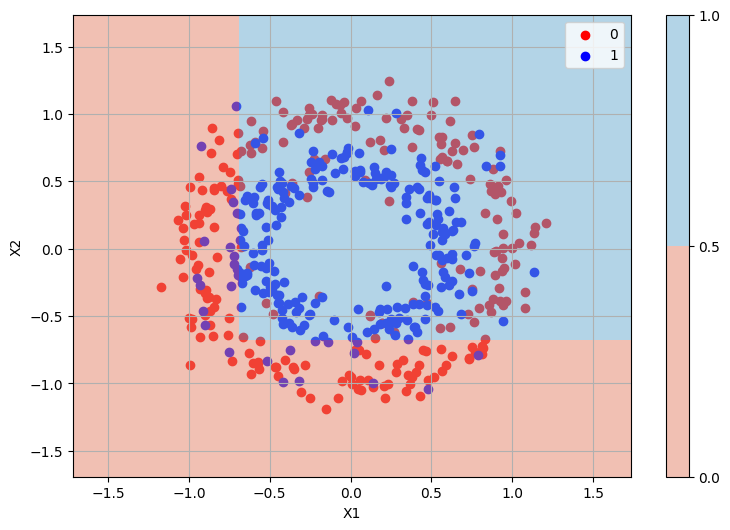

Max_depth:  4
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       251
           1       0.84      0.83      0.84       249

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



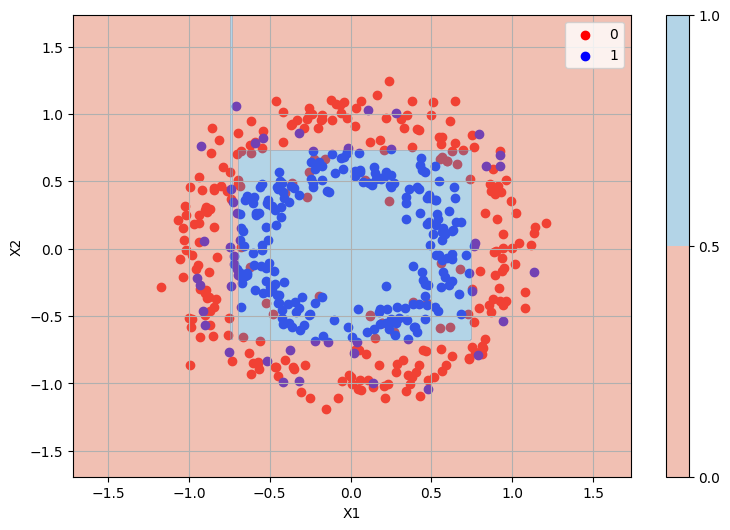

Max_depth:  7
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       251
           1       0.84      0.80      0.82       249

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



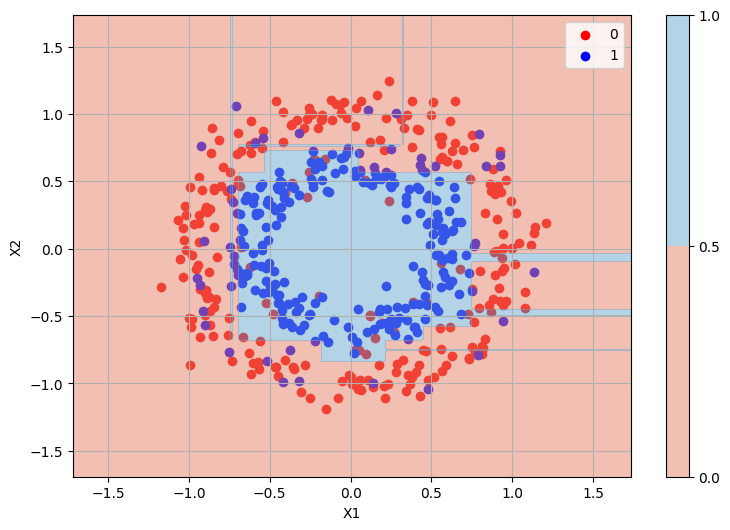

Max_depth:  10
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       251
           1       0.82      0.81      0.82       249

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



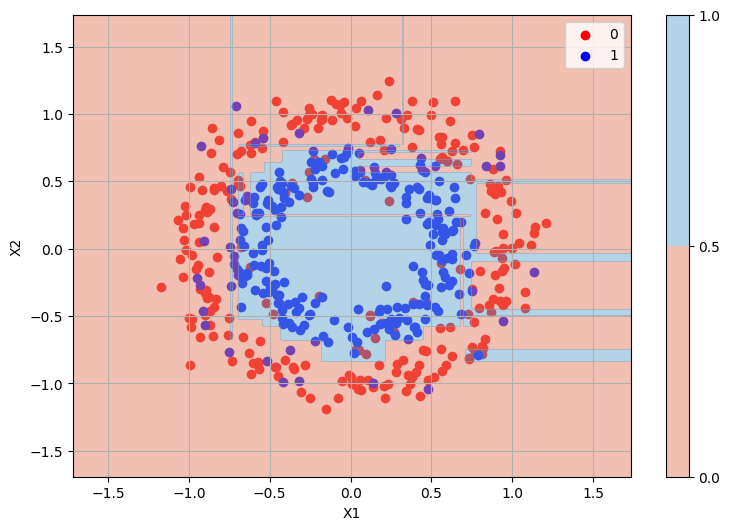

Max_depth:  15
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       251
           1       0.83      0.79      0.81       249

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



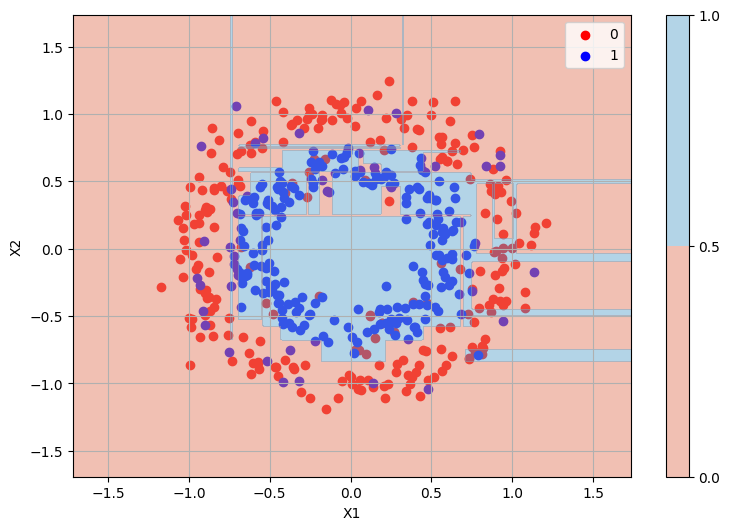

Max_depth:  25
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       251
           1       0.82      0.79      0.81       249

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



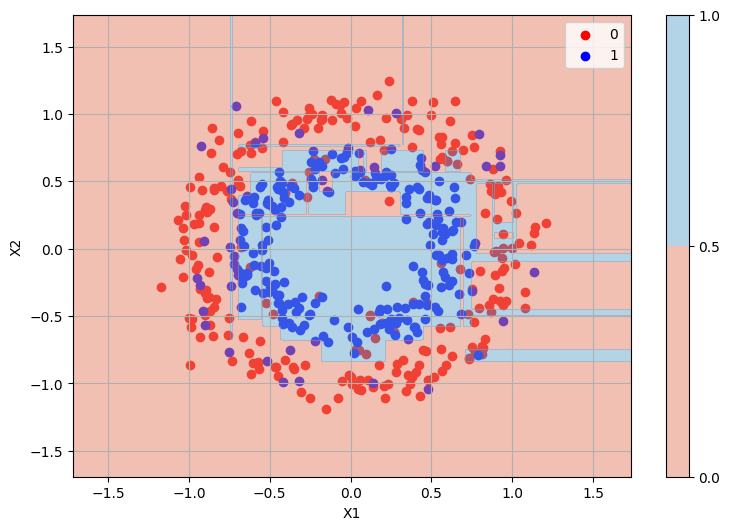

Max_depth:  50
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       251
           1       0.83      0.79      0.81       249

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



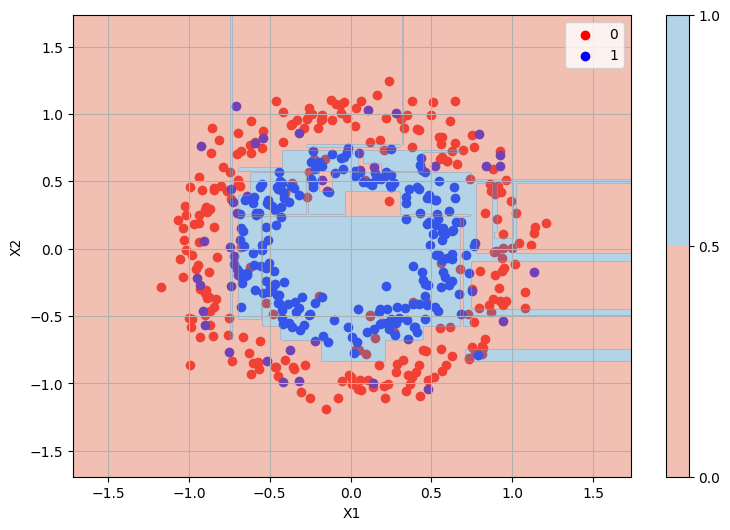

In [27]:
%time
for depth in [1,2,4,7,10,15,25,50]:
    print('Max_depth: ', depth)
    clf = DecisionTreeClassifier(max_depth=depth, criterion='gini')
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(classification_report(y_test, pred))
    plot_desicion_boundaries()

**Question:** What can you say about `max_depth` connetion with overfitting? What is the optimal value for this parameter in this case?

**Min samples leaf**

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.15 µs
Min samples leaf =  1
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       251
           1       0.82      0.78      0.80       249

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



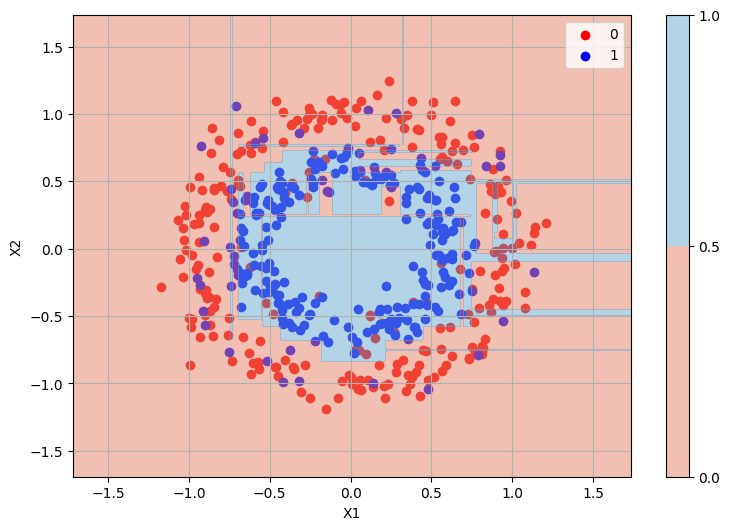

Min samples leaf =  10
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       251
           1       0.86      0.79      0.82       249

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



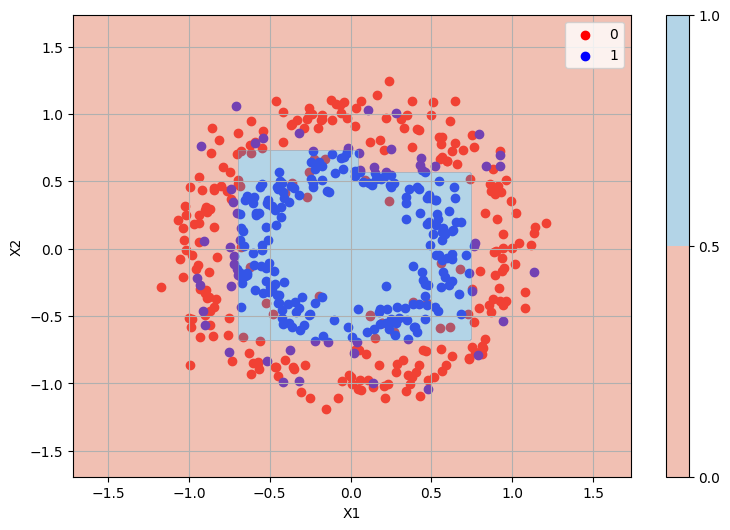

Min samples leaf =  25
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       251
           1       0.85      0.83      0.84       249

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



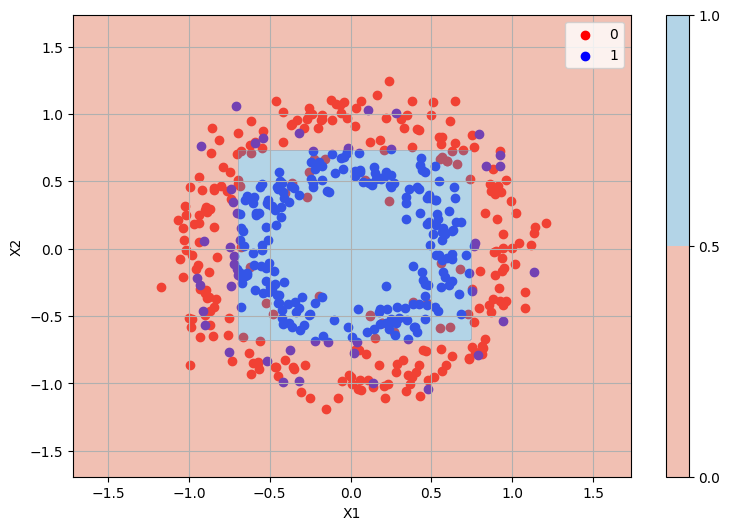

Min samples leaf =  50
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       251
           1       0.85      0.83      0.84       249

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



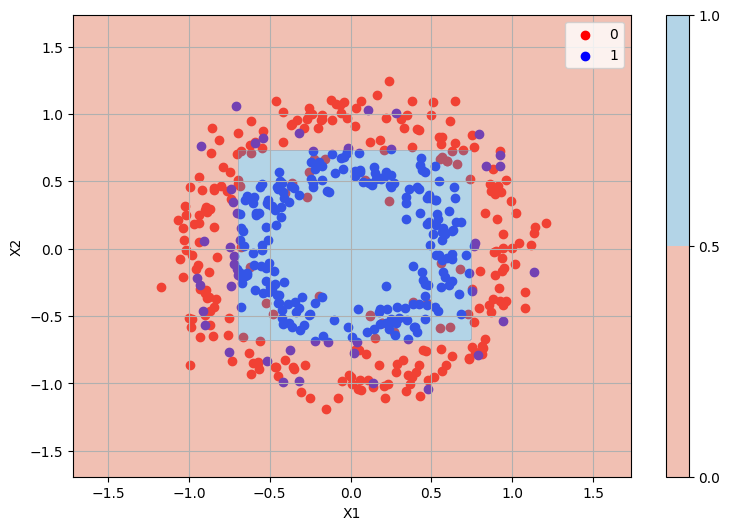

In [28]:
%time
for sample in [1,10,25, 50]:
    print('Min samples leaf = ', sample)
    clf = DecisionTreeClassifier(min_samples_leaf = sample, criterion='gini')
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(classification_report(y_test, pred))
    plot_desicion_boundaries()

**Question:** What can you say about `min_sample_leaf` connetion with overfitting? What is the optimal value for this parameter in this case?

**Task:** Study the influence of other parameters and make conclusions.

In [29]:
## YOUR CODE HERE

# Decision Tree Regressor

Decision trees can also be used for regression problems. In these case the prediction in the `Leaf` is the mean value of training labels in it.

**Data for regression problem** [California Housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html)



```
Features:
* MedInc - median income in block
* HouseAge - median house age in block
* AveRooms - average number of rooms
* AveBedrms - average number of bedrooms
* Population - block population
* AveOccup - average house occupancy
* Latitude - house block latitude
* Longitude - house block longitude

*Target: housing prices.
```





In [30]:
from sklearn.datasets import fetch_california_housing
bunch = fetch_california_housing()
df = pd.DataFrame(bunch['data'], columns=bunch['feature_names'])
df['target'] = bunch['target']
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [32]:
X = df.drop('target', axis=1)
Y = df['target']
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((16512, 8), (4128, 8), (16512,), (4128,))

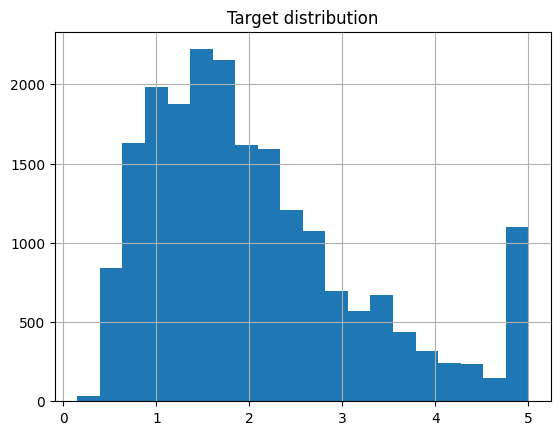

In [34]:
import seaborn as sns

plt.hist(Y, bins =20)
plt.title('Target distribution')
plt.grid()

## Metric

For regression problem we will use RMSE error:

$$
RMSE = \sqrt{MSE} = \sqrt{\sum_i^N(y_i - pred_i)^2}
$$

In [35]:
def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y_hat, y))

In [36]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(random_state=0)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
print('RMSE: ', round(rmse(Y_test, pred),3))

RMSE:  0.704


Not bad, but probably we could do better.

In [37]:
# Import GridSearchCV class
from sklearn.model_selection import GridSearchCV

# Define Decision Tree classifier with default parameters
clf = DecisionTreeRegressor()

# Estimate grid of the classifier hyperparameters
parameters = {
    'max_depth':[ 1, 3, 5, 7, 9],
    'min_samples_leaf': [1, 5,10]
}

# Define GridSearch parameters
gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='neg_mean_squared_error',  # Classification quality metric to optimize
                  cv=3)                # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(X_train, Y_train)
gs.best_params_

{'max_depth': 9, 'min_samples_leaf': 10}

In [38]:
pred = gs.predict(X_test)
print('RMSE: ', round(rmse(Y_test, pred),3))

RMSE:  0.627


Congratulation! RMSE has decreased!

# Out-of-sample extrapolation

An obvious limitation of decision tree regressor is that it basically can’t extrapolate on out-of-sample examples, whereas linear regression can.

**Question:** why?

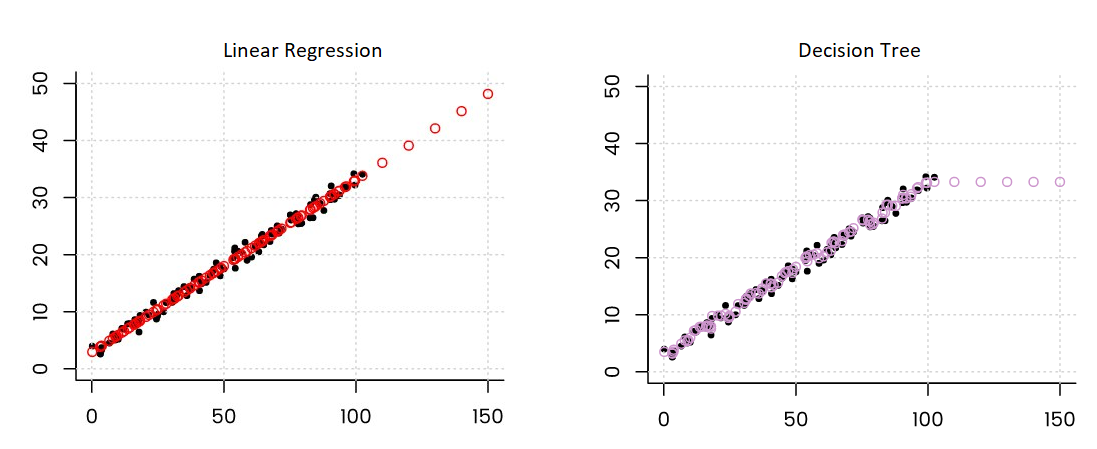

Let us observe this on the dataset. For this purpose we artificially put top 5% and bottom 5% into the test set. Then we chose 10% randomly for the rest of the test.

In [39]:
print('5% percentile = ', round(df.target.quantile(0.05),3))
print('95% percentile = ', round(df.target.quantile(0.95),3))

5% percentile =  0.662
95% percentile =  4.898


In [40]:
df_test = df[(df.target < df.target.quantile(0.05)) | (df.target > df.target.quantile(0.95))]
# top and bottom 5%
df_train = df[(df.target > df.target.quantile(0.05)) & (df.target < df.target.quantile(0.95))]

# 10% more for test chosen randomly
df_train, df_test_add =  train_test_split(df_train, test_size=0.1, random_state=42)

#join both parts of test set
df_test = pd.concat([df_test, df_test_add])
print('Train proportion: ', round(df_train.shape[0]/df.shape[0],3))
print('Test proportion: ', round(df_test.shape[0]/df.shape[0],3))

Train proportion:  0.81
Test proportion:  0.19


In [41]:
df_test = df_test.sort_values('target')
X_train = df_train.drop('target', axis=1)
Y_train = df_train['target']
X_test = df_test.drop('target', axis=1)
Y_test = df_test['target']

In [42]:
clf = DecisionTreeRegressor()
parameters = {'max_depth':[1, 3, 5, 7, 9],
              'min_samples_leaf':[1, 5, 10]}

gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='neg_mean_squared_error',  # Claasification quality metric to optimize
                  cv=3)                # Number of folds in KFolds cross-validation (CV)
gs.fit(X_train, Y_train)
pred = gs.predict(X_test)
print('RMSE: ', round(rmse(Y_test, pred),3))

RMSE:  0.887


In [43]:
print('Min train: ', min(Y_train),'\tMax train: ', max(Y_train))
print('Min pred: ', round(min(pred),3), '\tMax pred', round(max(pred),3))
print('Min test: ', round(min(Y_test),3),'\tMax test', round(max(Y_test),3))


Min train:  0.663 	Max train:  4.898
Min pred:  0.766 	Max pred 4.644
Min test:  0.15 	Max test 5.0


It can be observed that all predictions lie within the train distribution and do not extrapolate to the out-of-distribution test examples.

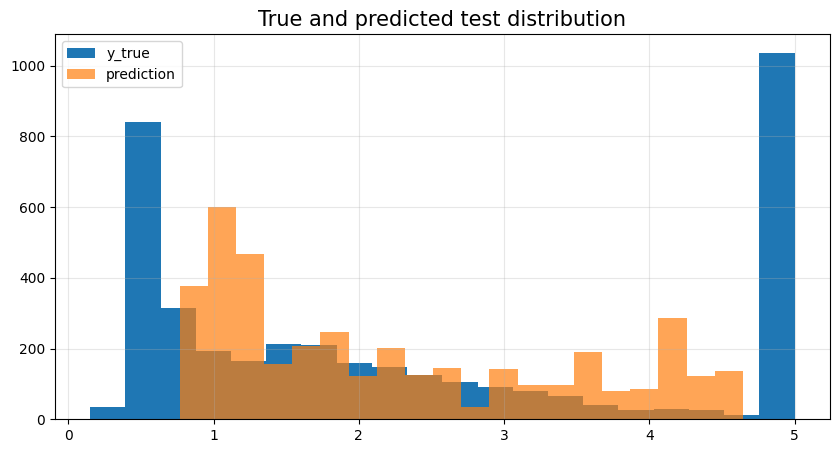

In [44]:
plt.figure(figsize = (10,5))
plt.grid(alpha = 0.3)
plt.hist(Y_test, bins = 20, label = 'y_true')
plt.hist(pred, alpha = 0.7, bins = 20, label = 'prediction' )
plt.title('True and predicted test distribution', size = 15)
plt.legend()

More information on extrapolation in [this post](http://freerangestats.info/blog/2016/12/10/extrapolation).

## Handling missing values

Decision trees could not work with missing values. Thus, we can either employ standard methods (mean, meadian, etc.) or use something more advanced.

For example, we can try to predict missing values with additional decision tree built on the rest of the features. To illustrate this method let's drop 5% of `HouseAge` values.



In [45]:
good_index, missing_index = train_test_split(df.index, test_size = 0.05, random_state = 1)
# drop 5% of values
df.HouseAge.loc[missing_index] = np.nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    19608 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


/var/folders/h0/z7lpdx1d2l5gfkb9nt4d_rjc0000gn/T/ipykernel_5289/797092938.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.HouseAge.loc[missing_index] = np.nan


In [46]:
#columns used for predicting missing values
use_cols = [x for x in df.columns if not x in ['HouseAge', 'target']]
use_cols

['MedInc',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [47]:
clf = DecisionTreeRegressor()
# training the tree
clf.fit(df.loc[good_index][use_cols], df.loc[good_index].HouseAge)

# predicting missing values
predicted_age = clf.predict(df.loc[missing_index][use_cols])

# filling in missing values
df.HouseAge[missing_index] = predicted_age
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


/var/folders/h0/z7lpdx1d2l5gfkb9nt4d_rjc0000gn/T/ipykernel_5289/3325041853.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.HouseAge[missing_index] = predicted_age


In [48]:
X = df.drop('target', axis=1)
Y = df['target']
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
clf = DecisionTreeRegressor()
parameters = {'max_depth':[1, 3, 5, 7, 9],
              'min_samples_leaf':[1, 5, 10]}

gs = GridSearchCV(clf,                 # Classifier object to optimize
                  parameters,          # Grid of the hyperparameters
                  scoring='neg_mean_squared_error',  # Claasification quality metric to optimize
                  cv=3)                # Number of folds in KFolds cross-validation (CV)
gs.fit(X_train, Y_train)
pred = gs.predict(X_test)
print('RMSE: ', round(rmse(Y_test, pred),3))

RMSE:  0.633


Congratulations!

The score is less than the original $RMSE = 0.627$, but the decrease is not big.

Read more information about handling missing values in [this post](https://stats.stackexchange.com/questions/98953/why-doesnt-random-forest-handle-missing-values-in-predictors?noredirect=1&lq=1).